In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

from scipy.ndimage.filters import convolve

from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA,IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

C:\Users\juanf\AppData\Local\Temp\ipykernel_19880\3682096890.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


## EXPLANATION OF THE PARAMETERS TO BE SET:

##### 1) "exp_id"
    It is used to provide an identification to the experiments developed

##### 2) "GSD": 
    This parameter refers to the Ground Sampling Distance of the inputs to be used. 
    
    The possibleoptions are 30 or 300.

##### 3) "norm"
    It specifies the normalization technique to be applied:
    
    - Standard Scaling: The parameter must be set to "Standard_30" or "Standard_300" (depending the GSD of the input data), 
    - Min max scaling: If this normalization technique is desired the param must be set to "minmax_300" (just for 300 m GSD inputs), 
    - Normalization to reflectance units: the param should take the value "reflectance" (just for 300 m GSD inputs)

##### 4) "data_augm"
    Parameter which determines if data augmentation must be applied on the input data.
    
    Possible values: True or False

##### 5) "model_ml"
    This parameter is used to define the model typology to be considered. The options are "SVR" for
    selecting Support Vector Regressor model and "RF" for choosing Random Forest Regressor Model.

##### 6) Specific parameters of the ML models
    For the SVR model can be set the following parameters: 
     
        "gamma":This is the kernel coefficient for the RBF kernel and it determines
        the shape of the decision boundary.

        "C": Controls the width of the margin and how many data points are allowed to be misclassified.
    
    In the case of the RF model could be set: 
    
        "n_trees": Number of decision trees.

        "min_leaf": This parameter determines the minimum number of samples to be a leaf node of the tree (to take a decision).

        "mx_dep": Maximum depth of each decision tree: By increasing its value is also possible to achieve more complex 
                models and then conduce to overfitting.


## Params and Utils

In [40]:
exp_id="SVR-4"
GSD=300 
norm= "Standard_300" 
data_augm = False
PCA_check=True 
model_ml = "SVR"

gamma = 0.001 
C = 15 
n_trees = 1000
min_leaf = 2
mx_dep = 20

In [41]:
workdir="./data/inputs/intersected_inputs/"

In [42]:
def get_8_neighbors(img, kernel_type):
    # define the 8-neighbor kernel
    
    if kernel_type =="normal":
        kernel = np.ones((3, 3))/9
    
    if kernel_type == "sobel_x":
        kernel = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    if kernel_type == "sobel_y":
        kernel = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])
    
    # apply convolution to obtain the 8-neighbor pixels
    neighbors = np.zeros_like(img)
    for i in range(img.shape[0]):
        neighbors[i] = convolve(img[i], kernel)

    # repeat the neighbors 8 times and stack them
    augmented_neighbors = np.concatenate([neighbors]*8, axis=1)
    augmented = np.concatenate([img, augmented_neighbors], axis=1)

    return augmented

def to_vector(id,limit, mode):

    if GSD==30:
        labels_ras=rio.open(workdir+f"GT_30_no_anomalies/{str(id)}.tif")
     
    if GSD==300:
        labels_ras=rio.open(workdir+f"GT_300_no_anomalies/{str(id)}.tif")
          
    labels_np=labels_ras.read()
        
    shape_labels=labels_np.shape  
        
    labels_np=np.moveaxis(labels_np, 0, 2)
    
    if GSD==30:
        features_ras=rio.open(workdir+f"PRS_imgs/{str(id)}.tif")
    
    if GSD==300:
        features_ras=rio.open(workdir+f"PRS_imgs_300/{str(id)}.tif")
        
    features_np=features_ras.read()
    
    features_np=features_np*(labels_np[:,:,0]!=0.)
    
    shape_features=features_np.shape
    
    features_np=features_np[:limit,:,:]
    
    if mode=="train" and data_augm:
        features_normal=get_8_neighbors(features_np, "normal")
        features_sobel_x=get_8_neighbors(features_np, "sobel_x")
        features_sobel_y=get_8_neighbors(features_np, "sobel_y")
        features_np = np.concatenate([features_normal, features_sobel_x, features_sobel_y], axis=1)
        
    features_np=np.moveaxis(features_np, 0, 2)
    
    features=np.reshape(features_np,(features_np.shape[0]*features_np.shape[1],features_np.shape[2]))
    print(features.shape)
    
    labels=np.reshape(labels_np,(labels_np.shape[0]*labels_np.shape[1],labels_np.shape[2]))
    print(labels.shape)
    
    if mode =="train" and data_augm:
        labels=np.concatenate([labels]*9*3, axis=0)
        
    return features, labels, shape_features, shape_labels 

## Preparing input data

### Preparing train data

In [43]:
list_train_ids = [1,2,6,10,13,17,18,19,21]

In [44]:
a=pd.DataFrame()
st_feat=[]
length=0
ids=[]
start_arr=[]
end_arr=[]
shp_arr_ft=[]
shp_arr_lbs=[]

for idx,i in enumerate(list_train_ids):
    
    features, labels, shape_features, shape_labels=to_vector(i,230,"train")

    ids.append(i)
    shp_arr_ft.append(shape_features)
    shp_arr_lbs.append(shape_labels)
    start_arr.append(length)
    length+=shape_labels[1]*shape_labels[2]
    end_arr.append(length)
    
    if idx==0:
        st_feat_train=features
        st_lbs_train=labels
    else:
        st_feat_train=np.vstack([st_feat_train,features])
        st_lbs_train=np.vstack([st_lbs_train,labels])
        
st_lbs_train = st_lbs_train.ravel()

(12084, 230)
(12084, 1)
(10752, 230)
(10752, 1)
(7259, 230)
(7259, 1)
(14030, 230)
(14030, 1)
(6832, 230)
(6832, 1)
(11316, 230)
(11316, 1)
(5292, 230)
(5292, 1)
(15006, 230)
(15006, 1)
(15744, 230)
(15744, 1)


In [45]:
df_train = pd.DataFrame(list(zip(ids, start_arr ,end_arr,shp_arr_ft, shp_arr_lbs)),
               columns =['id', 'start_idx', "end_idx","shape_features","shape_labels"])

df_train

,id,start_idx,end_idx,shape_features,shape_labels
0,1,0,12084,"(230, 106, 114)","(1, 106, 114)"
1,2,12084,22836,"(230, 84, 128)","(1, 84, 128)"
2,6,22836,30095,"(230, 119, 61)","(1, 119, 61)"
3,10,30095,44125,"(230, 115, 122)","(1, 115, 122)"
4,13,44125,50957,"(230, 112, 61)","(1, 112, 61)"
5,17,50957,62273,"(230, 92, 123)","(1, 92, 123)"
6,18,62273,67565,"(230, 54, 98)","(1, 54, 98)"
7,19,67565,82571,"(230, 122, 123)","(1, 122, 123)"
8,21,82571,98315,"(230, 123, 128)","(1, 123, 128)"


### Preparing test data

In [47]:
list_test_ids= [4,23,24]

In [48]:
a=pd.DataFrame()
st_feat=[]
length=0
ids=[]
start_arr=[]
end_arr=[]
shp_arr_ft=[]
shp_arr_lbs=[]

for idx,i in enumerate(list_test_ids):
    
    features, labels, shape_features, shape_labels =to_vector(i,230,"test")
    ids.append(i)
    shp_arr_ft.append(shape_features)
    shp_arr_lbs.append(shape_labels)
    start_arr.append(length)
    length+=shape_labels[1]*shape_labels[2]
    end_arr.append(length)
    
    if idx==0:
        st_feat_test=features
        st_lbs_test=labels
    else:
        st_feat_test=np.vstack([st_feat_test,features])
        st_lbs_test=np.vstack([st_lbs_test,labels])
        
st_lbs_test = st_lbs_test.ravel()

(9744, 230)
(9744, 1)
(9920, 230)
(9920, 1)
(8850, 230)
(8850, 1)


In [49]:
df_test = pd.DataFrame(list(zip(ids, start_arr ,end_arr,shp_arr_ft, shp_arr_lbs)),
               columns =['id', 'start_idx', "end_idx","shape_features","shape_labels"])

df_test

,id,start_idx,end_idx,shape_features,shape_labels
0,4,0,9744,"(230, 84, 116)","(1, 84, 116)"
1,23,9744,19664,"(230, 80, 124)","(1, 80, 124)"
2,24,19664,28514,"(230, 118, 75)","(1, 118, 75)"


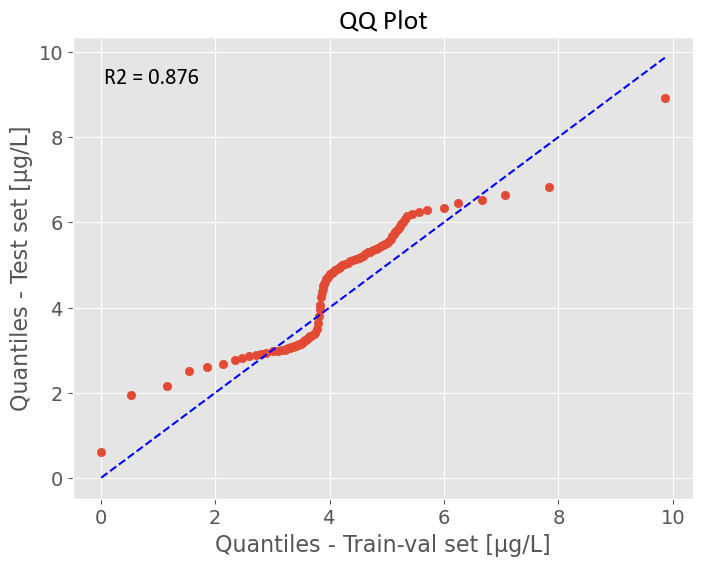

In [51]:
from scipy import stats


plt.style.use('ggplot')

plt.figure(figsize=[8,6])

# Generate two example data sets
data1 = st_lbs_train[st_lbs_train!=0]
data2 = st_lbs_test[st_lbs_test!=0]

# Calculate the quantiles of the two data sets
quantiles_data1 = np.linspace(0, 100, 100)
quantiles_data2 = np.linspace(0, 100, 100)
q1 = np.percentile(data1, quantiles_data1)
q2 = np.percentile(data2, quantiles_data2)

# Create the QQ plot
plt.scatter(q1, q2)
plt.xlabel('Quantiles - Train-val set [µg/L]', fontsize=16)
plt.ylabel('Quantiles - Test set [µg/L]', fontsize=16)
plt.title('QQ Plot',fontsize=20, fontname="Calibri")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

# Add the reference diagonal line
min_value = min(q1[0], q2[0])
max_value = max(q1[-1], q2[-1])
plt.plot([min_value, max_value], [min_value, max_value], color='blue', linestyle='dashed')

# Calculate the R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(q1, q2)
r_squared = r_value**2
plt.text(0.05, 0.9, f'R2 = {r_squared:.3f}', transform=plt.gca().transAxes, fontname="Calibri", fontsize=16)

plt.savefig(f"./output_results/data_split.jpg")

In [ ]:
fit_stack = np.vstack((st_feat_train,st_feat_test))

In [53]:
if norm=="Standard_300":
    scaler=StandardScaler()
    scaler.fit(fit_stack)
    
if norm=="minmax_300":
    scaler=MinMaxScaler()
    scaler.fit(fit_stack) # calculo la media para poder hacer la transformacion

if PCA_check==True and GSD==300:
    pca = PCA(n_components=30)
    pca.fit(fit_stack)
    
if norm=="Standard_30" and PCA_check==True and GSD==30:
    # create a StandardScaler object to scale the data
    scaler = StandardScaler()
    # create an IncrementalPCA object
    n_components = 30  # set the number of principal components
    batch_size = 10000  # set the size of each batch
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    # loop through the dataset and fit the PCA model in batches
    for X_batch in np.array_split(fit_stack, batch_size):
        # scale the batch
        scaler.partial_fit(X_batch)
        # fit the batch to the PCA model
        ipca.partial_fit(X_batch)
        
if norm=="Standard_30" and PCA_check==False and GSD==30:
    # create a StandardScaler object to scale the data
    scaler = StandardScaler()
    batch_size = 10000  # set the size of each batch
    for X_batch in np.array_split(fit_stack, batch_size):
        # scale the batch
        scaler.partial_fit(X_batch)

## Model definition and training

In [54]:
if norm=="Standard_300" or norm=="minmax_300" and GSD==300:
    X_train_scaled=scaler.transform(st_feat_train)
    if PCA_check==False:
        X_train = X_train_scaled
        
if PCA_check==True and GSD==300:
    X_train=pca.transform(X_train_scaled)

if norm=="Standard_30" and PCA_check==True and GSD==30:
    X_train_scaled=scaler.transform(st_feat_train)
    X_train_transformed = np.zeros((len(X_train_scaled), 30))
    for i in range(0, len(X_train_scaled), batch_size):
        X_batch = X_train_scaled[i:i+batch_size]
        X_batch_scaled = scaler.transform(X_batch)
        X_train_transformed[i:i+batch_size] = ipca.transform(X_batch_scaled)
    X_train = X_train_transformed

if norm == "Standard_30" and PCA_check == False and GSD == 30:
    batch_size = 1000
    # Create a memory-mapped file with zeros
    X_train_transformed = np.memmap("X_train_transformed.dat", dtype='float32', mode='w+', shape=(len(st_feat_train), 230))
    for i in range(0, len(X_train_transformed), batch_size):
        X_batch = st_feat_train[i:i+batch_size]
        X_batch_scaled = scaler.transform(X_batch)
        # Write the scaled batch to the memory-mapped array
        X_train_transformed[i:i+batch_size] = X_batch_scaled
    # Assign the memory-mapped array to X_train
    X_train = X_train_transformed

if norm=="reflectance":
    X_train_scaled=st_feat_train/2**16
    X_train = X_train_scaled

In [55]:
stkd_fts = X_train[st_lbs_train!=0.]

In [56]:
stkd_lbs = st_lbs_train[st_lbs_train!=0.]

In [57]:
X = stkd_fts
y = stkd_lbs

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'original data')

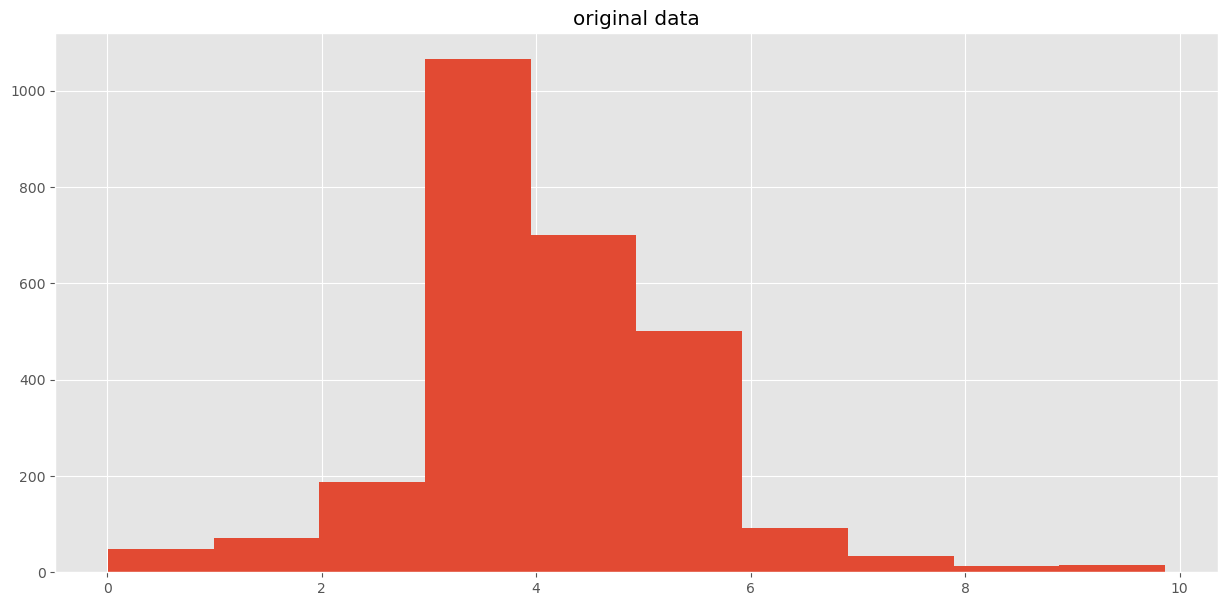

In [59]:
plt.figure(figsize=[15,7])
plt.hist(y_train.ravel())
plt.title("original data")

In [60]:
if model_ml == "SVR":
    clf =svm.SVR(kernel='rbf', gamma=gamma, C=C)
if model_ml =="RF":
    clf = RandomForestRegressor(n_estimators = n_trees,min_samples_leaf=min_leaf, max_depth=mx_dep , random_state = 42)

In [61]:
st=time.time()
clf.fit(X_train, y_train)
et=time.time()
print((et-st)/60, "mins")

0.00949766238530477 mins


In [62]:
score = clf.score(X_val, y_val)
print("R2: %.2f%%" % (score * 100.0))

R2: 20.92%


In [63]:
import joblib
joblib.dump(clf, f"./models/{exp_id}.joblib")

['./models/SVR-4.joblib']

## Inference

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [65]:
if norm=="Standard_300" or norm=="minmax_300" and GSD==300:
    X_test_scaled=scaler.transform(st_feat_test)# Ahora si, escalo los datos y los normalizo
    if PCA_check==False:
        X_test = X_test_scaled
        
if PCA_check and GSD==300:
    X_test=pca.transform(X_test_scaled)

if norm=="Standard_30" and PCA_check and GSD==30:
    X_test_scaled=scaler.transform(st_feat_test)
    X_test_transformed = np.zeros((len(X_test_scaled), 30))
    for i in range(0, len(X_test_scaled), batch_size):
        X_batch = X_test_scaled[i:i+batch_size]
        X_batch_scaled = scaler.transform(X_batch)
        X_test_transformed[i:i+batch_size] = ipca.transform(X_batch_scaled)

    X_test = X_test_transformed
    
if norm == "Standard_30" and PCA_check == False and GSD == 30:
    batch_size = 1000
    # Create a memory-mapped file with zeros
    X_test_transformed = np.memmap("X_test_transformed.dat", dtype='float32', mode='w+', shape=(len(st_feat_test), 230))
    for i in range(0, len(X_test_transformed), batch_size):
        X_batch = st_feat_test[i:i+batch_size]
        X_batch_scaled = scaler.transform(X_batch)
        # Write the scaled batch to the memory-mapped array
        X_test_transformed[i:i+batch_size] = X_batch_scaled
    # Assign the memory-mapped array to X_train
    X_test = X_test_transformed
    
if norm=="reflectance":
    X_test_scaled=st_feat_test/2**16
    X_test = X_test_scaled

In [66]:
test_preds = clf.predict(X_test.astype("float32"))

In [67]:
preds=np.array(test_preds)

In [68]:
pred_masked=[]

In [69]:
preds_arr=np.array([])
mae_score=np.array([])
rmse_score=np.array([])

for i,r in df_test.iterrows():
    id_img = r.id
    start_idx=r.start_idx
    end_idx=r.end_idx
    shape_labels=r.shape_labels
    reshaped_pred=np.reshape(preds[start_idx:end_idx],shape_labels)
    
    print(reshaped_pred.shape)
    pred_metric=reshaped_pred[0]
    gt=np.reshape(st_lbs_test[start_idx:end_idx],shape_labels)[0]
    
    pred_masked=np.reshape((reshaped_pred[0,:,:]),(shape_labels[1]*shape_labels[2],1))

    if i==0:
        pred_mask_arr=pred_masked
        mae_score=mean_absolute_error(gt[gt!=0], pred_metric[gt!=0])
        rmse_score=mean_squared_error(gt[gt!=0], pred_metric[gt!=0], squared=False)

    else:
        pred_mask_arr=np.vstack([pred_mask_arr,pred_masked])
        mae_score=np.hstack([mae_score, mean_absolute_error(gt[gt!=0], pred_metric[gt!=0])])
        rmse_score=np.hstack([rmse_score, mean_squared_error(gt[gt!=0], pred_metric[gt!=0], squared=False)])
        
    if GSD==300:
        meta=rio.open(f"./data/inputs/intersected_inputs/PRS_imgs_300/{id_img}.tif").meta
        
    if GSD==30:
        meta=rio.open(f"./data/inputs/intersected_inputs/PRS_imgs/{id_img}.tif").meta
        
    meta["count"]=1
    with rio.open(f"./outputs_tifs/output tifs v2/id_{id_img}_exp_{exp_id}.tif", mode="w", **meta) as new_dataset:
        new_dataset.write(np.clip(reshaped_pred,0,100))

(1, 84, 116)
(1, 80, 124)
(1, 118, 75)


In [71]:
mae_score,mae_score.mean(), rmse_score,rmse_score.mean()

(array([0.534753  , 0.7157308 , 0.81607697]),
 0.6888535900508622,
 array([0.68110749, 0.9640862 , 1.04317107]),
 0.8961215865037432)

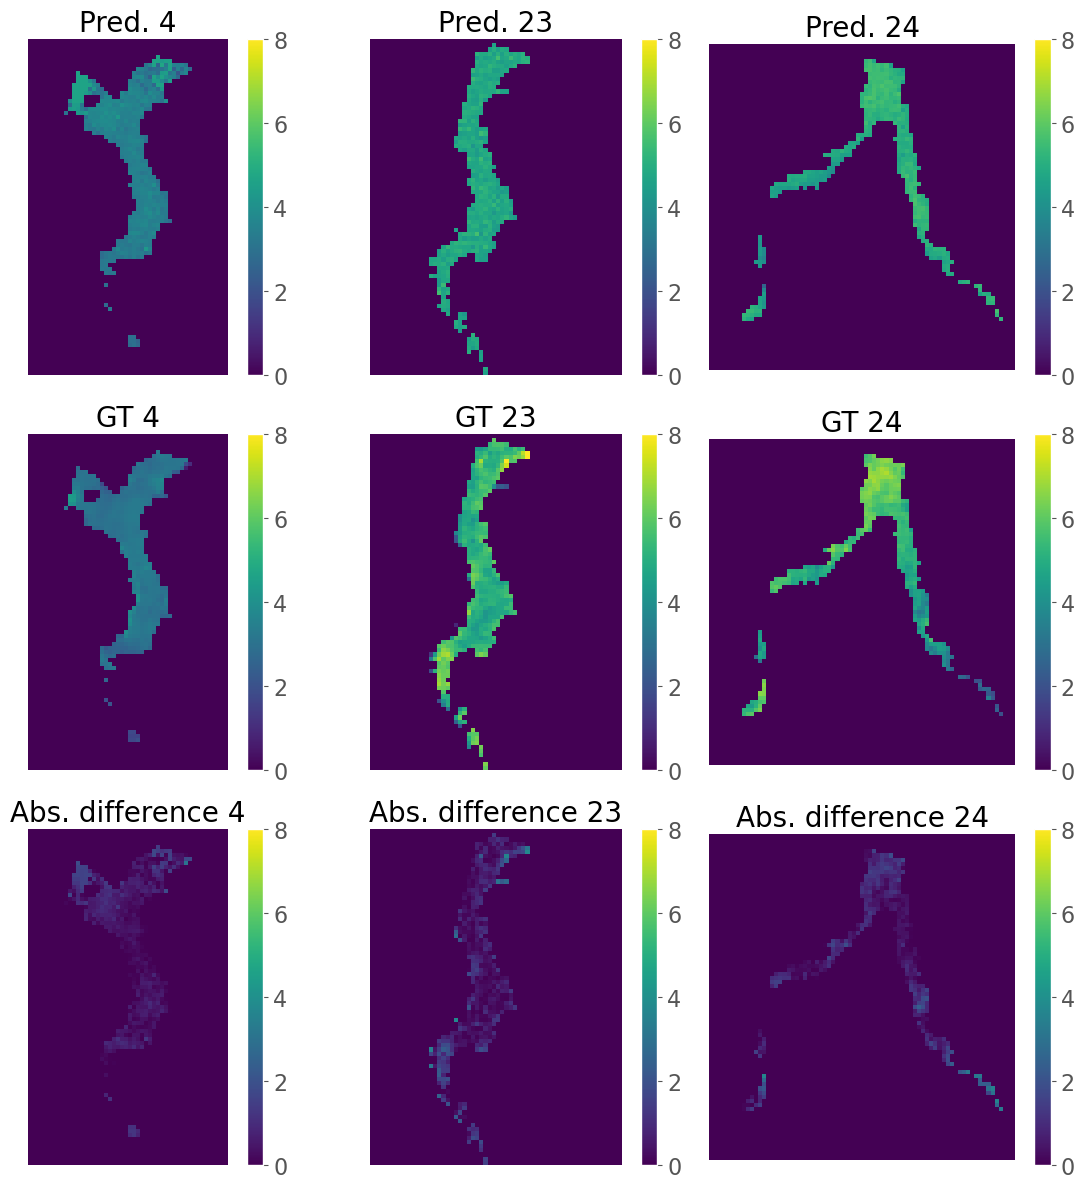

In [73]:
ls=16
fs=20

if GSD==300:

    pred1=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[0])}_exp_{exp_id}.tif").read()[0,:,:50]
    pred2=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[1])}_exp_{exp_id}.tif").read()[0,:,:60]
    pred3=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[2])}_exp_{exp_id}.tif").read()[0,:80,:]
    
    gt1=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[0])}.tif").read()[0,:,:50]
    gt2=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[1])}.tif").read()[0,:,:60]
    gt3=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[2])}.tif").read()[0,:80,:]

if GSD==30:

    pred1=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[0])}_exp_{exp_id}.tif").read()[0,:,:500]
    pred2=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[1])}_exp_{exp_id}.tif").read()[0,:,:600]
    pred3=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[2])}_exp_{exp_id}.tif").read()[0,:800,:]

    gt1=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[0])}.tif").read()[0,:,:500]
    gt2=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[1])}.tif").read()[0,:,:600]
    gt3=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[2])}.tif").read()[0,:800,:]

    
dif1=abs(gt1-pred1)
dif2=abs(gt2-pred2)
dif3=abs(gt3-pred3)

plt.figure(figsize=[12,12])

plt.subplot(3,3,1)
im1 =plt.imshow(pred1*(gt1!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[0])}", fontsize=fs)
cbar1 = plt.colorbar(im1)
cbar1.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,2)
im2 =plt.imshow(pred2*(gt2!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[1])}", fontsize=fs)
cbar2 = plt.colorbar(im2)
cbar2.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,3)
im3 =plt.imshow(pred3*(gt3!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[2])}", fontsize=fs)
cbar3 = plt.colorbar(im3)
cbar3.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,4)
im4 = plt.imshow(gt1, vmax=8)
plt.title(f"GT {str(list_test_ids[0])}", fontsize=fs)
cbar4 = plt.colorbar(im4)
cbar4.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,5)
im5 = plt.imshow(gt2, vmax=8)
plt.title(f"GT {str(list_test_ids[1])}", fontsize=fs)
cbar5 = plt.colorbar(im5)
cbar5.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,6)
im6 = plt.imshow(gt3, vmax=8)
plt.title(f"GT {str(list_test_ids[2])}", fontsize=fs)
cbar6 = plt.colorbar(im6)
cbar6.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,7)
im7 = plt.imshow(dif1*(gt1!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[0])}", fontsize=fs)
cbar7 = plt.colorbar(im7)
cbar7.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,8)
im8 = plt.imshow(dif2*(gt2!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[1])}", fontsize=fs)
cbar8 = plt.colorbar(im8)
cbar8.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,9)
im9 = plt.imshow(dif3*(gt3!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[2])}", fontsize=fs)
cbar9 = plt.colorbar(im9)
cbar9.ax.tick_params(labelsize=ls)
plt.axis('off') 

plt.tight_layout()

plt.savefig(f"./output_results/results_{exp_id}_maps.jpg")

C:\Users\juanf\AppData\Local\Temp\ipykernel_19880\1858816670.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


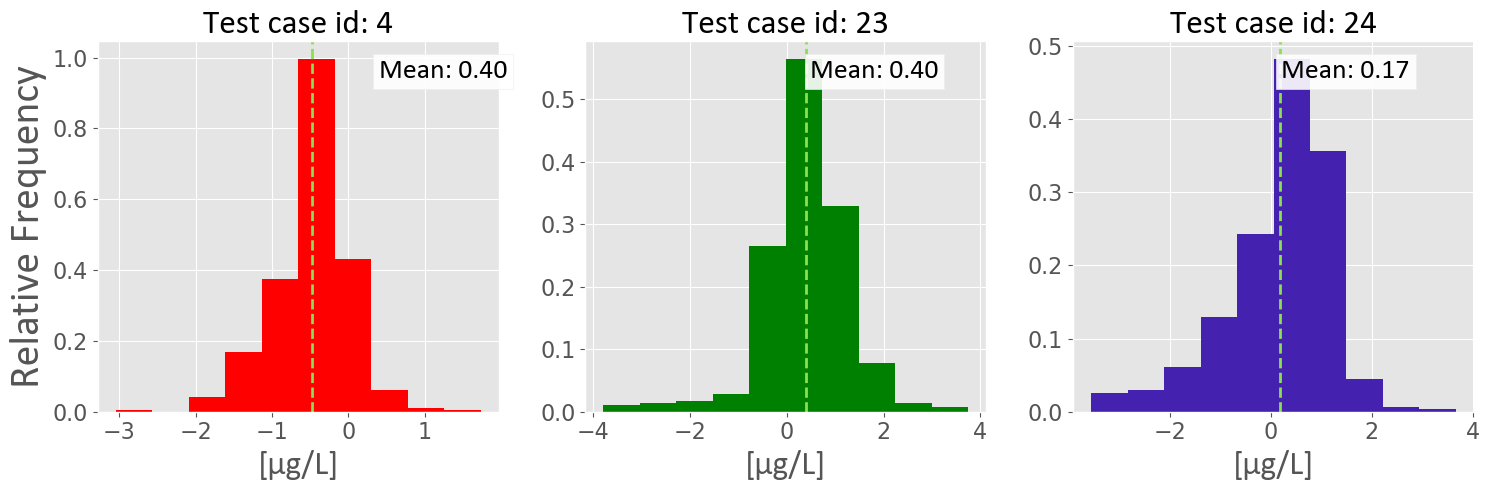

In [74]:
plt.style.use('ggplot')

fs=24

dif1_check=(gt1-pred1)*(gt1!=0)
dif1_check=dif1_check[dif1_check!=0]

dif2_check=(gt2-pred2)*(gt2!=0)
dif2_check=dif2_check[dif2_check!=0]

dif3_check=(gt3-pred3)*(gt3!=0)
dif3_check=dif3_check[dif3_check!=0]

plt.figure(figsize=[15,5])

plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(1,3,1)
plt.hist(dif1_check, color="red", density=True)
plt.title("Test case id: 4",fontsize=fs, fontname="Calibri")
plt.axvline(dif1_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.ylabel("Relative Frequency", fontname='Calibri', fontsize=30)
min_ylim, max_ylim = plt.ylim()
plt.text(dif2_check.mean(), max_ylim*0.9 , 'Mean: {:.2f}'.format(dif2_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(1,3,2)
plt.hist(dif2_check, color="green", density=True)
plt.title("Test case id: 23",fontsize=fs, fontname="Calibri")
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.axvline(dif2_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(dif2_check.mean()*1.2, max_ylim*0.9 , 'Mean: {:.2f}'.format(dif2_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(1,3,3)
plt.hist(dif3_check, color="#4421af", density=True)
plt.title("Test case id: 24",fontsize=fs, fontname="Calibri")
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.axvline(dif3_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(dif3_check.mean()*1.2, max_ylim*0.9 , 'Mean: {:.2f}'.format(dif3_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

plt.savefig(f"./output_results/results_{exp_id}.jpg")

## Export results in CSV format

In [75]:
import csv

# Define the data for the report
data = [
    {'exp_id': exp_id, 'Spatial resolution': GSD, 'Dimensionality reduction': PCA_check,"Normalization technique":norm,
    "gamma": gamma, "C":C, "n_trees":n_trees, "min_leaf":min_leaf, "mx_dep":mx_dep,"model_ml":model_ml, "MAE general": mae_score.mean() , "RMSE general":rmse_score.mean(),
     "MAE 4":mae_score[0], "RMSE 4":rmse_score[0], "MAE 23":mae_score[1],"RMSE 23":rmse_score[1] , "MAE 24":mae_score[2] ,"RMSE 24":rmse_score[2]}
]

# Open a new file and create a csv.writer object
with open(f'./output_results/outputs_v2/results_{exp_id}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['exp_id', 'Spatial resolution', 'Dimensionality reduction', "Normalization technique",
                    "gamma", "C", "n_trees", "min_leaf", "mx_dep","model_ml", "MAE general", "RMSE general",
                     "MAE 4", "RMSE 4", "MAE 23","RMSE 23", "MAE 24","RMSE 24"])

    # Loop through the data and write each row to the CSV file
    for row in data:
        writer.writerow([row['exp_id'], row['Spatial resolution'], row['Dimensionality reduction'], 
                        row["Normalization technique"], row["gamma"],row["C"],
                        row["n_trees"],row["min_leaf"], row["mx_dep"],row["model_ml"],
                        row["MAE general"],row["RMSE general"], row["MAE 4"], row["RMSE 4"], 
                        row["MAE 23"],row["RMSE 23"], row["MAE 24"],row["RMSE 24"]])